<div align="center">

<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2024/01/logo_telecom_ipparis_rvb_fond_h.png" alt="Telecom Paris Logo" width="300"/>

---

# **Projet Big Data - EDA**
## *IADATA700 - Kit Big Data*

# 📈 Analyse statistique / Recettes / Long-Terme

In [1]:
import sys
sys.path.append('../../')

# Forcer le rechargement de notre module
from _data_utils import *

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings

from scipy import stats
from scipy.stats import spearmanr, kendalltau, kruskal, chi2_contingency, chisquare, kstest
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

warnings.filterwarnings('ignore')

# Configuration graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Import réussi !")

✅ _data_utils module chargé (common + ratings + recipes)
✅ Import réussi !


## 📥 Chargement des données

In [2]:
# 🚀 Pipeline complet : charge + nettoie + enrichit
df = load_clean_recipes()

print(f"✅ Dataset prêt : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['year'].min()} - {df['year'].max()}")

# 📊 Rapport de qualité
report = analyze_recipe_quality(df)

1️⃣ Chargement des données brutes...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ Recettes chargées depuis S3 : 231,637 lignes × 12 colonnes

2️⃣ Nettoyage des données...
🧹 Nettoyage des recettes...
   ✓ 18,482 recettes avec minutes invalides (<1 ou >180)
   ℹ️  Seuils calculés (IQ 90% = Q5%-Q95%):
      • n_steps: [2, 24] (médiane=9, moyenne=9.7)
      • n_ingredients: [3, 17] (médiane=9, moyenne=9.0)
   ✓ 13,088 recettes avec n_steps ou n_ingredients aberrants (hors IQ 90%)
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)

3️⃣ Enrichissement des features...
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales

4️⃣ Sauvegarde sur S3...
✅ Sauvegardé vers s3://mangetamain/final_recipes.parquet (200,066 lignes, format=parquet)
💾 Dataset final sauvegardé : s3://mangetamain/final_recipes.parquet

✅ Pipeline complet terminé !
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...

📋 RAPPORT DE QUALITÉ - RAW_RECIPES
📦 Dimensions : 200,066 lignes × 28 colonnes
🔄 Doublons :

## Analyse statistique

### Analyse 1 : Évolution du volume de recettes
#### Visualisation

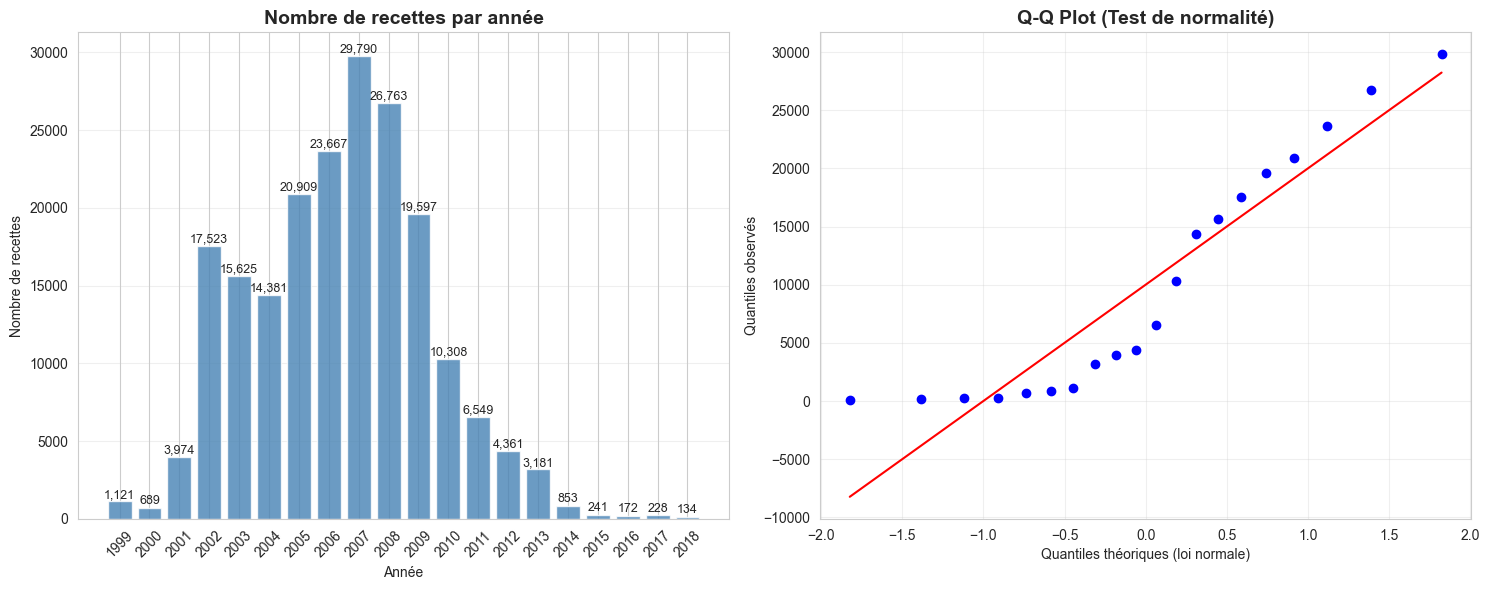

In [3]:
from scipy.stats import shapiro, normaltest
from scipy import stats

recipes_per_year = (df.group_by("year").agg(pl.len().alias("n_recipes")).sort("year").to_pandas())

# Préparation des données pour le Q-Q plot
data = recipes_per_year['n_recipes'].values
mean_data = np.mean(data)
std_data = np.std(data, ddof=1)

# --- VISUALISATION : Fréquence + Q-Q Plot ---
fig, (ax1, ax0) = plt.subplots(1, 2, figsize=(15, 6))

# (1) Graphique de fréquence (barres)
bars = ax1.bar(recipes_per_year['year'].astype(int), recipes_per_year['n_recipes'], 
               color='steelblue', alpha=0.8)
ax1.set_title('Nombre de recettes par année', fontsize=14, fontweight='bold')
ax1.set_xlabel('Année')
ax1.set_ylabel('Nombre de recettes')
ax1.set_xticks(recipes_per_year['year'].astype(int))
ax1.set_xticklabels(recipes_per_year['year'].astype(int), rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Annotations des valeurs
for bar, val in zip(bars, recipes_per_year['n_recipes']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{val:,}', ha='center', va='bottom', fontsize=9)

# (2) Q-Q Plot (test de normalité)
stats.probplot(data, dist="norm", plot=ax0)
ax0.set_title('Q-Q Plot (Test de normalité)', fontsize=14, fontweight='bold')
ax0.set_xlabel('Quantiles théoriques (loi normale)')
ax0.set_ylabel('Quantiles observés')
ax0.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Tests statistiques

In [4]:
from scipy.stats import shapiro, normaltest, kstest
from scipy import stats

# Récupération des données (déjà calculées dans la cellule précédente)
data = recipes_per_year['n_recipes'].values
n = len(data)
mean_data = np.mean(data)
std_data = np.std(data, ddof=1)

# --- TESTS STATISTIQUES DE NORMALITÉ ---
print("="*80)
print("📊 TESTS DE NORMALITÉ - NOMBRE DE RECETTES PAR ANNÉE")
print("="*80)

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(data)
print(f"\n1️⃣ TEST DE SHAPIRO-WILK :")
print(f"   • Statistique W      : {shapiro_stat:.6f}")
print(f"   • p-value            : {shapiro_p:.6f}")
print(f"   • Résultat           : {'✅ NORMAL' if shapiro_p > 0.05 else '❌ NON NORMAL'} (α = 0.05)")

# Test de D'Agostino-Pearson
dagostino_stat, dagostino_p = normaltest(data)
print(f"\n2️⃣ TEST DE D'AGOSTINO-PEARSON :")
print(f"   • Statistique K²     : {dagostino_stat:.6f}")
print(f"   • p-value            : {dagostino_p:.6f}")
print(f"   • Résultat           : {'✅ NORMAL' if dagostino_p > 0.05 else '❌ NON NORMAL'} (α = 0.05)")

# Statistiques descriptives
print(f"\n3️⃣ STATISTIQUES DESCRIPTIVES :")
print(f"   • Moyenne            : {mean_data:.2f}")
print(f"   • Écart-type         : {std_data:.2f}")
print(f"   • Coefficient variation : {(std_data/mean_data)*100:.1f}%")
print(f"   • Médiane            : {np.median(data):.0f}")
print(f"   • Min - Max          : {data.min():.0f} - {data.max():.0f}")

print("\n" + "="*80)

📊 TESTS DE NORMALITÉ - NOMBRE DE RECETTES PAR ANNÉE

1️⃣ TEST DE SHAPIRO-WILK :
   • Statistique W      : 0.861946
   • p-value            : 0.008508
   • Résultat           : ❌ NON NORMAL (α = 0.05)

2️⃣ TEST DE D'AGOSTINO-PEARSON :
   • Statistique K²     : 3.532839
   • p-value            : 0.170944
   • Résultat           : ✅ NORMAL (α = 0.05)

3️⃣ STATISTIQUES DESCRIPTIVES :
   • Moyenne            : 10003.30
   • Écart-type         : 10100.64
   • Coefficient variation : 101.0%
   • Médiane            : 5455
   • Min - Max          : 134 - 29790



#### Interprétation

> **💡 Interprétation:** 
>
> Nous observons une **forte augmentation du nombre de recettes postées jusqu’en 2007**, année du **pic d’activité**, suivie d’une **chute marquée** les années suivantes. 
>
> Les **tests de normalité** et les **Q-Q plots** montrent que la distribution du **nombre de recettes par an** **n’est pas parfaitement normale**, avec des **écarts visibles** par rapport à la **loi normale théorique**. 
>    

### Analyse 2: Évolution de la durée moyenne
#### Visualisation

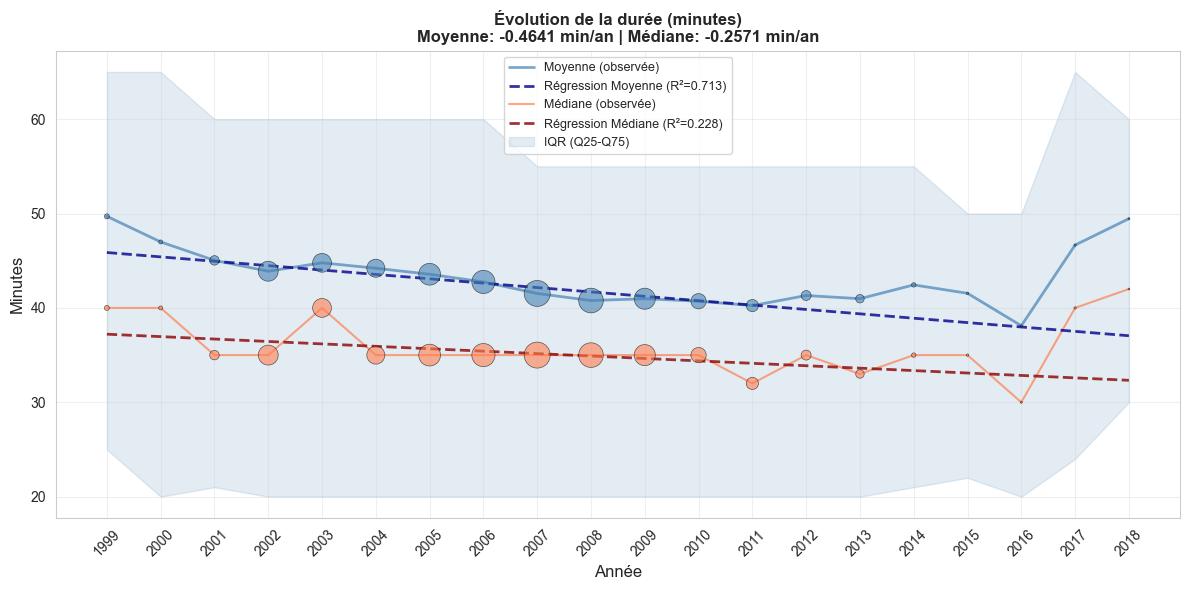

In [5]:
# 📊 Agrégation durée par année
minutes_by_year = (
    df.group_by("year")
    .agg([
        pl.mean("minutes").alias("mean_minutes"), 
        pl.median("minutes").alias("median_minutes"),
        pl.quantile("minutes", 0.25).alias("q25"), 
        pl.quantile("minutes", 0.75).alias("q75"), 
        pl.len().alias("n_recipes")
    ])
    .sort("year").to_pandas()
)

# --- CALCUL DES RÉGRESSIONS WLS POUR MEAN ET MEDIAN ---
import statsmodels.api as sm

X = minutes_by_year['year'].values
w = minutes_by_year['n_recipes'].values

metrics_config = {
    'mean_minutes': {
        'color': 'steelblue', 
        'label': 'Moyenne',
        'ylabel': 'minutes/an'
    },
    'median_minutes': {
        'color': 'coral',
        'label': 'Médiane',
        'ylabel': 'minutes/an'
    }
}

regressions = {}
for metric_col in metrics_config.keys():
    y = minutes_by_year[metric_col].values
    X_const = sm.add_constant(X)
    wls_model = sm.WLS(y, X_const, weights=w)
    wls_result = wls_model.fit()
    y_pred = wls_result.predict(X_const)
    r2_w = 1 - np.average((y - y_pred)**2, weights=w) / np.average((y - np.average(y, weights=w))**2, weights=w)
    
    regressions[metric_col] = {
        'y_pred': y_pred,
        'slope': wls_result.params[1],
        'intercept': wls_result.params[0],
        'r2': r2_w,
        'p_value': wls_result.pvalues[1]
    }

# --- VISUALISATION AVEC RÉGRESSIONS ---
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

sizes = minutes_by_year['n_recipes'] / minutes_by_year['n_recipes'].max() * 350

# Moyenne : courbe + bulles + régression
ax1.plot(minutes_by_year['year'], minutes_by_year['mean_minutes'], 
         color='steelblue', linewidth=2, alpha=0.7, label='Moyenne (observée)', zorder=1)
ax1.scatter(minutes_by_year['year'], minutes_by_year['mean_minutes'], 
            s=sizes, color='steelblue', alpha=0.6, edgecolors='black', linewidths=0.5, zorder=3)
ax1.plot(minutes_by_year['year'], regressions['mean_minutes']['y_pred'],
         color='darkblue', linewidth=2, linestyle='--', alpha=0.8,
         label=f"Régression Moyenne (R²={regressions['mean_minutes']['r2']:.3f})", zorder=2)

# Médiane : courbe + bulles + régression
ax1.plot(minutes_by_year['year'], minutes_by_year['median_minutes'], 
         color='coral', linewidth=1.5, alpha=0.7, label='Médiane (observée)', zorder=1)
ax1.scatter(minutes_by_year['year'], minutes_by_year['median_minutes'], 
            s=sizes, color='coral', alpha=0.6, edgecolors='black', linewidths=0.5, zorder=3)
ax1.plot(minutes_by_year['year'], regressions['median_minutes']['y_pred'],
         color='darkred', linewidth=2, linestyle='--', alpha=0.8,
         label=f"Régression Médiane (R²={regressions['median_minutes']['r2']:.3f})", zorder=2)

# IQR (intervalle interquartile)
ax1.fill_between(minutes_by_year['year'], minutes_by_year['q25'], minutes_by_year['q75'], 
                 alpha=0.15, color='steelblue', label='IQR (Q25-Q75)', zorder=0)

# Titres et légendes
title_text = (f"Évolution de la durée (minutes)\n"
              f"Moyenne: {regressions['mean_minutes']['slope']:+.4f} min/an | "
              f"Médiane: {regressions['median_minutes']['slope']:+.4f} min/an")
ax1.set_title(title_text, fontsize=12, fontweight='bold')
ax1.set_xlabel('Année', fontsize=12)
ax1.set_ylabel('Minutes', fontsize=12)
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(minutes_by_year['year'])
ax1.set_xticklabels([int(y) for y in minutes_by_year['year']], rotation=45)

plt.tight_layout()
plt.show()

#### Tests statistiques

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata
import statsmodels.api as sm

def weighted_spearman(x, y, w):
    """Corrélation de Spearman pondérée par les poids w"""
    # Conversion en rangs
    rx = rankdata(x)
    ry = rankdata(y)
    # Moyennes pondérées des rangs
    mx = np.average(rx, weights=w)
    my = np.average(ry, weights=w)
    # Covariance et écarts-types pondérés
    cov_xy = np.average((rx - mx) * (ry - my), weights=w)
    sx = np.sqrt(np.average((rx - mx)**2, weights=w))
    sy = np.sqrt(np.average((ry - my)**2, weights=w))
    return cov_xy / (sx * sy)

# Variables pour l'analyse
x = minutes_by_year['year']
y = minutes_by_year['mean_minutes']
w = minutes_by_year['n_recipes']  # Poids = nombre de recettes

# --- STATISTIQUES DESCRIPTIVES ---
print("="*80)
print("📊 STATISTIQUES DESCRIPTIVES")
print("="*80)
print(f"\nDurée moyenne (mean_minutes) :")
print(f"   • Moyenne pondérée   : {np.average(y, weights=w):.2f} min")
print(f"   • Min - Max          : {y.min():.2f} → {y.max():.2f} min")
print(f"   • Médiane (années)   : {y.median():.2f} min")

# --- CORRÉLATION ---
spearman_corr_w = weighted_spearman(x, y, w)
print(f"\n📈 CORRÉLATION")
print(f"   • Spearman pondérée  : {spearman_corr_w:+.4f}")

# --- RÉGRESSION WLS ---
X = sm.add_constant(x)
wls_model = sm.WLS(y, X, weights=w)
wls_result = wls_model.fit()
y_pred = wls_result.predict(X)

# Calcul manuel du R² pondéré
r2_w = 1 - np.average((y - y_pred)**2, weights=w) / np.average((y - np.average(y, weights=w))**2, weights=w)

print(f"\n📉 RÉGRESSION WLS")
print(f"   • Pente              : {wls_result.params['year']:+.4f} min/an")
print(f"   • R² pondéré         : {r2_w:.4f} ({r2_w*100:.1f}%)")
print(f"   • p-value            : {wls_result.pvalues['year']:.6e}")
print(f"   • Significativité    : {'✅ OUI' if wls_result.pvalues['year'] < 0.05 else '❌ NON'} (α=0.05)")
print("\n" + "="*80)

📊 STATISTIQUES DESCRIPTIVES

Durée moyenne (mean_minutes) :
   • Moyenne pondérée   : 42.43 min
   • Min - Max          : 38.11 → 49.71 min
   • Médiane (années)   : 42.60 min

📈 CORRÉLATION
   • Spearman pondérée  : -0.8488

📉 RÉGRESSION WLS
   • Pente              : -0.4641 min/an
   • R² pondéré         : 0.7134 (71.3%)
   • p-value            : 2.813729e-06
   • Significativité    : ✅ OUI (α=0.05)



#### Interprétation

> **💡 Interprétation :**  
>  
> **L’analyse de la durée moyenne de préparation** montre une **tendance globale à la baisse** depuis la création du site.  
>  
> En moyenne, le temps de préparation diminue d’environ **−0.46/min par an**, tandis que la médiane recule de **−0.26/min par an**, ce qui traduit une **légère simplification des recettes** au fil du temps.  
>  
> Toutefois, malgré cette diminution statistique, la **durée moyenne reste stable autour de 40 minutes**, suggérant que les recettes continuent d’exiger un **temps de préparation modéré et constant** dans l’ensemble.

### Analyse 3: Évolution de la complexité
#### Visualisation

In [7]:
# Rappel du score de complexité: complexity_score = log1p(minutes) + n_steps + 0.5 * n_ingredients
# où log1p(m)= log(1+m)
# Corrélation entre ingrédients, étapes et minutes.

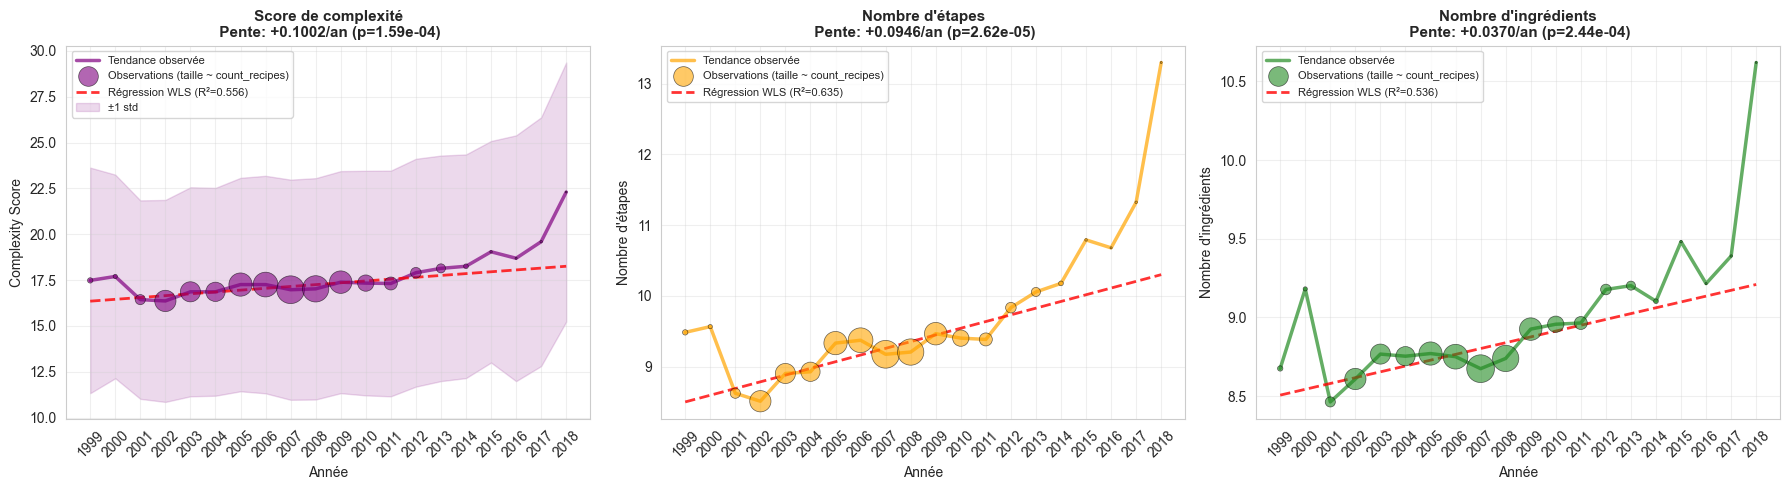

In [8]:
# 📊 Agrégation des données de complexité par année
complexity_by_year = (
    df.group_by("year")
    .agg([
        pl.mean("complexity_score").alias("mean_complexity"),
        pl.mean("n_steps").alias("mean_steps"),
        pl.mean("n_ingredients").alias("mean_ingredients"),
        pl.std("complexity_score").alias("std_complexity"),
        pl.count("id").alias("count_recipes")
    ])
    .sort("year").to_pandas()
)

# --- CALCUL DES RÉGRESSIONS WLS POUR LES 3 MÉTRIQUES ---
import statsmodels.api as sm

X = complexity_by_year['year'].values
w = complexity_by_year['count_recipes'].values

metrics_config = {
    'mean_complexity': {
        'color': 'purple', 'marker': 'o', 
        'title': 'Score de complexité', 
        'ylabel': 'Complexity Score',
        'show_std': True
    },
    'mean_steps': {
        'color': 'orange', 'marker': 's',
        'title': 'Nombre d\'étapes',
        'ylabel': 'Nombre d\'étapes',
        'show_std': False
    },
    'mean_ingredients': {
        'color': 'forestgreen', 'marker': '^',
        'title': 'Nombre d\'ingrédients',
        'ylabel': 'Nombre d\'ingrédients',
        'show_std': False
    }
}

# Calcul des régressions
regressions = {}
for metric_col in metrics_config.keys():
    y = complexity_by_year[metric_col].values
    X_const = sm.add_constant(X)
    wls_model = sm.WLS(y, X_const, weights=w)
    wls_result = wls_model.fit()
    y_pred = wls_result.predict(X_const)
    r2_w = 1 - np.average((y - y_pred)**2, weights=w) / np.average((y - np.average(y, weights=w))**2, weights=w)
    
    regressions[metric_col] = {
        'y_pred': y_pred,
        'slope': wls_result.params[1],
        'r2': r2_w,
        'p_value': wls_result.pvalues[1]
    }

# --- VISUALISATION AVEC RÉGRESSIONS ---
sizes = (w / w.max()) * 400
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (metric_col, config) in zip(axes, metrics_config.items()):
    reg = regressions[metric_col]
    
    # Courbe observée
    ax.plot(complexity_by_year['year'], complexity_by_year[metric_col],
            linewidth=2.5, color=config['color'], alpha=0.7,
            label='Tendance observée', zorder=1)
    
    # Bulles proportionnelles
    ax.scatter(complexity_by_year['year'], complexity_by_year[metric_col],
               s=sizes, alpha=0.6, color=config['color'],
               edgecolors='black', linewidths=0.5,
               label='Observations (taille ~ count_recipes)', zorder=3)
    
    # Ligne de régression
    ax.plot(complexity_by_year['year'], reg['y_pred'],
            color='red', linewidth=2, linestyle='--', alpha=0.8,
            label=f'Régression WLS (R²={reg["r2"]:.3f})', zorder=2)
    
    # Bande de std pour complexity_score
    if config.get('show_std'):
        ax.fill_between(complexity_by_year['year'],
                        complexity_by_year['mean_complexity'] - complexity_by_year['std_complexity'],
                        complexity_by_year['mean_complexity'] + complexity_by_year['std_complexity'],
                        alpha=0.15, color=config['color'], label='±1 std', zorder=0)

    title_text = f"{config['title']}\n Pente: {reg['slope']:+.4f}/an (p={reg['p_value']:.2e})"
    ax.set_title(title_text, fontsize=11, fontweight='bold')
    
    ax.set_xlabel('Année')
    ax.set_ylabel(config['ylabel'])
    ax.grid(True, alpha=0.3)
    ax.set_xticks(complexity_by_year['year'])
    ax.set_xticklabels([int(y) for y in complexity_by_year['year']], rotation=45)
    ax.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

#### Tests statistiques

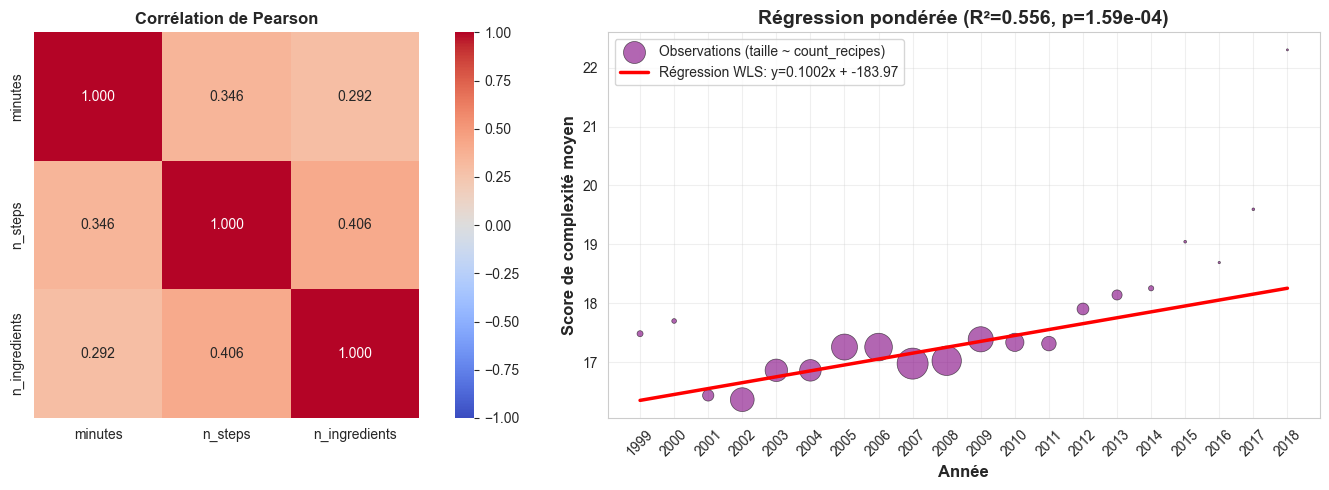

📊 RÉGRESSION LINÉAIRE PONDÉRÉE : complexity_score ~ year
Pente (β₁)            : +0.100208 points/an
Intercept (β₀)        : -183.9656
R² pondéré            : 0.5564 (55.6% variance expliquée)
p-value               : 1.593571e-04
Significativité       : ✅ OUI (α=0.05)


In [9]:
# 📊 Matrice de corrélation complète (minutes, n_steps, n_ingredients)
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import spearmanr

# Extraire les données en pandas pour faciliter l'analyse
corr_df = df.select(['minutes', 'n_steps', 'n_ingredients']).to_pandas()

# Calculer la matrice de corrélation de Pearson
pearson_corr = corr_df.corr(method='pearson')

# Variables pour la régression
X = complexity_by_year['year'].values
y = complexity_by_year['mean_complexity'].values
w = complexity_by_year['count_recipes'].values  # Poids = nombre de recettes

# Régression WLS (Weighted Least Squares)
X_const = sm.add_constant(X)
wls_model = sm.WLS(y, X_const, weights=w)
wls_result = wls_model.fit()

# Calcul manuel du R² pondéré (plus fiable)
y_pred = wls_result.predict(X_const)
r2_w = 1 - np.average((y - y_pred)**2, weights=w) / np.average((y - np.average(y, weights=w))**2, weights=w)

# Corrélation de Spearman (non pondérée, pour comparaison)
corr_sp, p_sp = spearmanr(X, y)

# Extraction des paramètres de régression
slope = wls_result.params[1]  # Pente (index 1)
intercept = wls_result.params[0]  # Constante (index 0)
p_value = wls_result.pvalues[1]  # p-value de la pente

# 📈 VISUALISATION
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# (1) Matrice de corrélation de Pearson
sns.heatmap(pearson_corr, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, ax=axes[0])
axes[0].set_title('Corrélation de Pearson', fontweight='bold', fontsize=12)

# (2) Régression linéaire avec bulles proportionnelles
sizes = w / w.max() * 500
axes[1].scatter(X, y, s=sizes, alpha=0.6, color='purple', 
           label='Observations (taille ~ count_recipes)', edgecolors='black', linewidths=0.5)
axes[1].plot(X, y_pred, color='red', linewidth=2.5, 
        label=f'Régression WLS: y={slope:.4f}x + {intercept:.2f}')
axes[1].set_xlabel('Année', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score de complexité moyen', fontsize=12, fontweight='bold')
axes[1].set_title(f'Régression pondérée (R²={r2_w:.3f}, p={p_value:.2e})', 
             fontsize=14, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(X)
axes[1].set_xticklabels([int(x) for x in X], rotation=45)

plt.tight_layout()
plt.show()

# 📊 Affichage des résultats
print("="*70)
print("📊 RÉGRESSION LINÉAIRE PONDÉRÉE : complexity_score ~ year")
print("="*70)
print(f"Pente (β₁)            : {slope:+.6f} points/an")
print(f"Intercept (β₀)        : {intercept:.4f}")
print(f"R² pondéré            : {r2_w:.4f} ({r2_w*100:.1f}% variance expliquée)")
print(f"p-value               : {p_value:.6e}")
print(f"Significativité       : {'✅ OUI' if p_value < 0.05 else '❌ NON'} (α=0.05)")


#### Interprétation

> **💡 Interprétation statistique :**  
> 
> La **régression linéaire pondérée** (pente = **+0.10**, R² = **0.56**, p = **1.59×10⁻⁴**) met en évidence une **tendance significative à la hausse** du **score moyen de complexité** au fil du temps.  
>
> Cette évolution indique une **augmentation progressive de la complexité des recettes**, d’environ **+0.10 point par an**, suggérant des **préparations de plus en plus élaborées** au cours des années.  
>
> La tendance observée est **cohérente** avec la corrélation positive entre le **nombre d’étapes** et le **nombre d’ingrédients**, confirmant une **complexification globale** des recettes publiées.


### Analyse 4: Évolution nutritionnelle
#### Visualisation

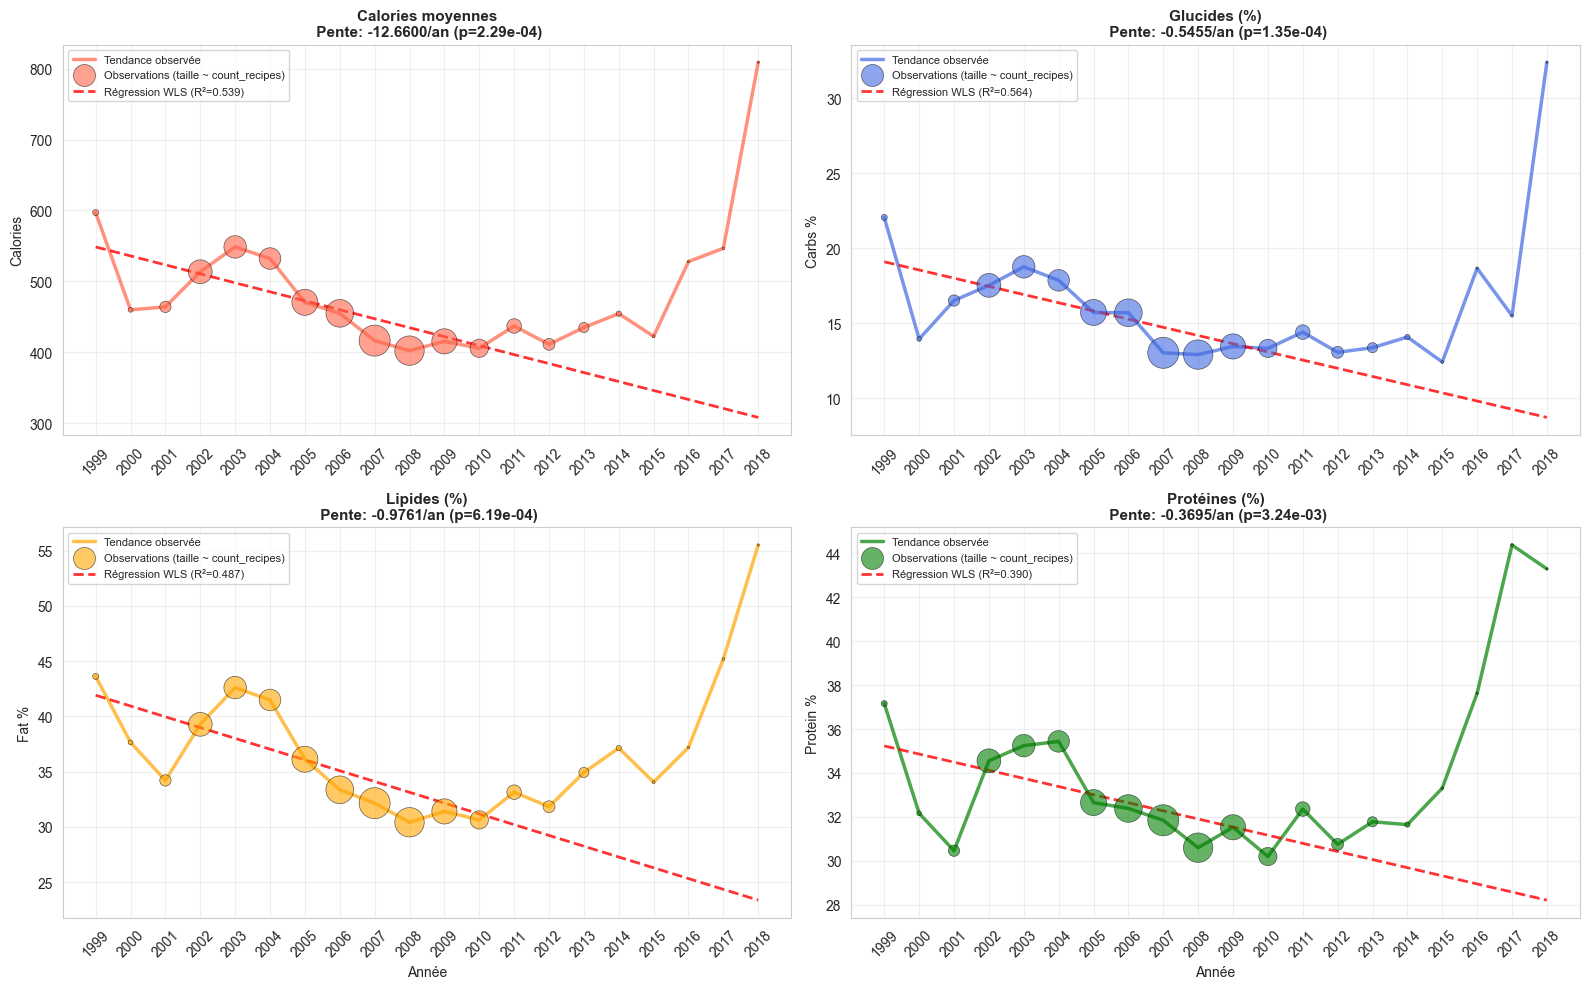

In [10]:
# 📊 Agrégation nutrition par année (Calories, Glucides, Lipides, Protéines)
nutrition_by_year = (
    df.group_by("year")
    .agg([pl.mean("calories").alias("mean_calories"), pl.mean("carb_pct").alias("mean_carbs"), 
          pl.mean("total_fat_pct").alias("mean_fat"), pl.mean("protein_pct").alias("mean_protein"),
          pl.count("id").alias("count_recipes")])
    .sort("year").to_pandas())

# --- CALCUL DES RÉGRESSIONS WLS POUR CHAQUE MÉTRIQUE ---
import statsmodels.api as sm

X_year = nutrition_by_year['year'].values
w = nutrition_by_year['count_recipes'].values

metrics_config = {
    'mean_calories': {'color': 'tomato', 'marker': 'o', 'title': 'Calories moyennes', 'ylabel': 'Calories'},
    'mean_carbs': {'color': 'royalblue', 'marker': 's', 'title': 'Glucides (%)', 'ylabel': 'Carbs %'},
    'mean_fat': {'color': 'orange', 'marker': '^', 'title': 'Lipides (%)', 'ylabel': 'Fat %'},
    'mean_protein': {'color': 'green', 'marker': 'd', 'title': 'Protéines (%)', 'ylabel': 'Protein %'}
}

regressions = {}
for metric_col in metrics_config.keys():
    y = nutrition_by_year[metric_col].values
    X_const = sm.add_constant(X_year)
    wls_model = sm.WLS(y, X_const, weights=w)
    wls_result = wls_model.fit()
    y_pred = wls_result.predict(X_const)
    r2_w = 1 - np.average((y - y_pred)**2, weights=w) / np.average((y - np.average(y, weights=w))**2, weights=w)
    
    regressions[metric_col] = {
        'y_pred': y_pred,
        'slope': wls_result.params[1],
        'intercept': wls_result.params[0],
        'r2': r2_w,
        'p_value': wls_result.pvalues[1]
    }

# --- CALCUL DES TAILLES DE BULLES ---
sizes = (w / w.max()) * 500  # Taille max = 500

# --- VISUALISATION AVEC COURBES + BULLES + RÉGRESSIONS ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes_flat = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]

for ax, (metric_col, config) in zip(axes_flat, metrics_config.items()):
    reg = regressions[metric_col]
    
    # Courbe originale (ligne continue)
    ax.plot(nutrition_by_year['year'], nutrition_by_year[metric_col], 
            linewidth=2.5, color=config['color'], alpha=0.7,
            label='Tendance observée', zorder=1)
    
    # Bulles (scatter) proportionnelles à count_recipes
    ax.scatter(nutrition_by_year['year'], nutrition_by_year[metric_col], 
               s=sizes, alpha=0.6, color=config['color'], 
               edgecolors='black', linewidths=0.5,
               label='Observations (taille ~ count_recipes)', zorder=3)
    
    # Ligne de régression
    ax.plot(nutrition_by_year['year'], reg['y_pred'], 
            color='red', linewidth=2, linestyle='--', alpha=0.8,
            label=f'Régression WLS (R²={reg["r2"]:.3f})', zorder=2)
    
    # Titre avec significativité
    title_text = f"{config['title']}\n Pente: {reg['slope']:+.4f}/an (p={reg['p_value']:.2e})"
    ax.set_title(title_text, fontsize=11, fontweight='bold')
    
    ax.set_ylabel(config['ylabel'])
    if ax in [axes[1,0], axes[1,1]]:
        ax.set_xlabel('Année')
    
    ax.grid(True, alpha=0.3)
    ax.set_xticks(nutrition_by_year['year'])
    ax.set_xticklabels([int(y) for y in nutrition_by_year['year']], rotation=45)
    ax.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

#### Tests statistiques

In [11]:
print("="*80)
print("📊 RÉSUMÉ DES RÉGRESSIONS LINÉAIRES PONDÉRÉES (WLS) - NUTRITION")
print("="*80)

# Affichage des résultats pour chaque métrique nutritionnelle
for metric_col, config in metrics_config.items():
    reg = regressions[metric_col]
    # Icône de significativité selon p-value
    sig_icon = '✅' if reg['p_value'] < 0.05 else '❌'
    
    print(f"\n📈 {config['title'].upper()}")
    print(f"   • Pente (β₁)         : {reg['slope']:+.6f} {config['ylabel']}/an")
    print(f"   • Intercept (β₀)     : {reg['intercept']:.4f}")
    print(f"   • R² pondéré         : {reg['r2']:.4f} ({reg['r2']*100:.1f}% variance expliquée)")
    print(f"   • p-value            : {reg['p_value']:.6e}")
    print(f"   • Significativité    : {sig_icon} {'OUI' if reg['p_value'] < 0.05 else 'NON'} (α=0.05)")
    print("-" * 80)

📊 RÉSUMÉ DES RÉGRESSIONS LINÉAIRES PONDÉRÉES (WLS) - NUTRITION

📈 CALORIES MOYENNES
   • Pente (β₁)         : -12.659994 Calories/an
   • Intercept (β₀)     : 25855.7884
   • R² pondéré         : 0.5388 (53.9% variance expliquée)
   • p-value            : 2.293671e-04
   • Significativité    : ✅ OUI (α=0.05)
--------------------------------------------------------------------------------

📈 GLUCIDES (%)
   • Pente (β₁)         : -0.545453 Carbs %/an
   • Intercept (β₀)     : 1109.4619
   • R² pondéré         : 0.5643 (56.4% variance expliquée)
   • p-value            : 1.347520e-04
   • Significativité    : ✅ OUI (α=0.05)
--------------------------------------------------------------------------------

📈 LIPIDES (%)
   • Pente (β₁)         : -0.976081 Fat %/an
   • Intercept (β₀)     : 1993.0989
   • R² pondéré         : 0.4874 (48.7% variance expliquée)
   • p-value            : 6.188384e-04
   • Significativité    : ✅ OUI (α=0.05)
-----------------------------------------------------

#### Interprétation

> **💡 Interprétation :**  
>
> Les **régressions linéaires pondérées** montrent une **tendance significative à la baisse** des valeurs **nutritionnelles moyennes** au fil du temps.  
>
> Les **calories**, **glucides**, **lipides** et **protéines** présentent toutes des **pentes négatives**, avec des **R² pondérés entre 0.39 et 0.56**, indiquant une **bonne part de variance expliquée** et une **diminution mesurable** des apports nutritionnels moyens par recette.  
>
> Cette évolution traduit une **orientation progressive vers des recettes plus légères**, moins riches en **calories** et en **macronutriments**, reflétant probablement une **adaptation aux tendances alimentaires modernes** (recherche de plats plus équilibrés et moins énergétiques).  

### Analyse 5: Évolution des ingrédients
#### Visualisation

🔄 Normalisation des ingrédients en cours...
✅ 1,762,665 ingrédients individuels extraits


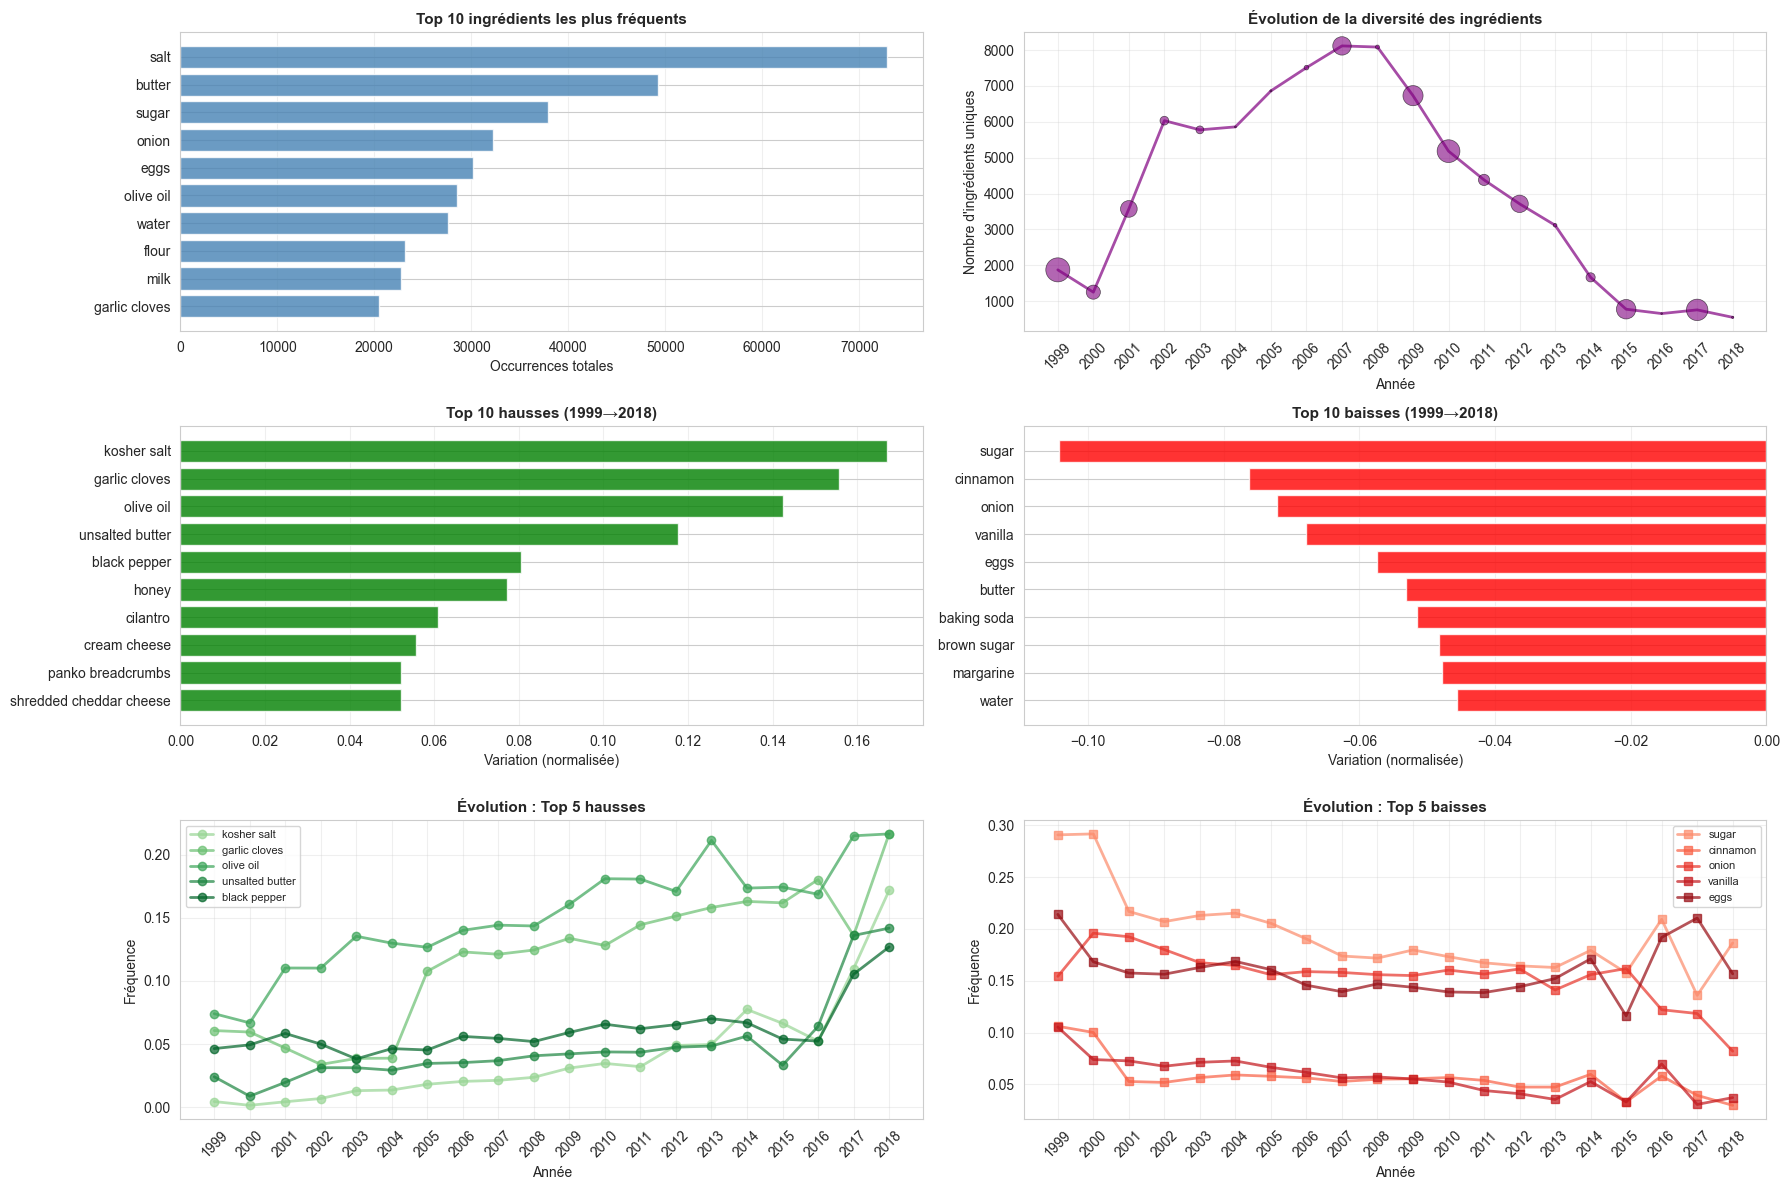


✅ Visualisation terminée !
   • 2,415 ingrédients analysés (≥ 50 occurrences)
   • Diversité : 1,872 (1999) → 548 (2018)


In [12]:
# 📊 ANALYSE DES INGRÉDIENTS PAR ANNÉE

# --- PARAMÈTRES ---
NORMALIZE = True  # Normaliser par le nb de recettes de l'année
MIN_TOTAL_OCC = 50  # Seuil min d'occurrences globales
TOP_N = 10  # Top hausses/baisses à afficher
N_VARIATIONS = 5  # Nombre d'ingrédients à tracer

# --- 0. PRÉPARATION : NORMALISATION DES INGRÉDIENTS ---
print("🔄 Normalisation des ingrédients en cours...")

# Exploser la liste d'ingrédients et normaliser (lowercase + strip)
df_ingredients = (
    df.select(['id', 'year', 'ingredients'])
    .explode('ingredients')
    .with_columns([
        pl.col('ingredients').str.to_lowercase().str.strip_chars().alias('ingredient_norm')
    ])
)

print(f"✅ {df_ingredients.shape[0]:,} ingrédients individuels extraits")

# --- 1. FRÉQUENCE GLOBALE DES INGRÉDIENTS ---
freq_global = (
    df_ingredients
    .group_by('ingredient_norm')
    .agg(pl.count('id').alias('total_count'))
    .filter(pl.col('total_count') >= MIN_TOTAL_OCC)
    .sort('total_count', descending=True)
    .to_pandas()
)

top_global = freq_global.head(TOP_N)

# --- 2. FRÉQUENCE PAR ANNÉE ---
freq_year_ing = (
    df_ingredients
    .group_by(['year', 'ingredient_norm'])
    .agg(pl.count('ingredient_norm').alias('count'))
    .to_pandas()
)

# Nombre de recettes par année
year_totals = df.group_by('year').agg(pl.count('id').alias('n_recipes')).to_pandas()

# Joindre et normaliser
freq_year_ing = freq_year_ing.merge(year_totals, on='year', how='left')
if NORMALIZE:
    freq_year_ing['freq'] = freq_year_ing['count'] / freq_year_ing['n_recipes']
else:
    freq_year_ing['freq'] = freq_year_ing['count']

# --- 3. CALCUL DES VARIATIONS ---
min_year = int(df['year'].min())
max_year = int(df['year'].max())

first_year_vals = freq_year_ing[freq_year_ing['year'] == min_year][['ingredient_norm', 'freq']].rename(columns={'freq': 'first'})
last_year_vals = freq_year_ing[freq_year_ing['year'] == max_year][['ingredient_norm', 'freq']].rename(columns={'freq': 'last'})

variation = first_year_vals.merge(last_year_vals, on='ingredient_norm', how='outer').fillna(0)
variation['delta'] = variation['last'] - variation['first']

# Filtrer pour avoir suffisamment d'occurrences
variation = variation.merge(freq_global[['ingredient_norm', 'total_count']], on='ingredient_norm', how='left')
variation = variation[variation['total_count'] >= MIN_TOTAL_OCC]

biggest_increase = variation.nlargest(TOP_N, 'delta')
biggest_decrease = variation.nsmallest(TOP_N, 'delta')

# --- 4. DIVERSITÉ (NOMBRE D'INGRÉDIENTS UNIQUES) ---
unique_per_year = (
    df_ingredients
    .group_by('year')
    .agg(pl.n_unique('ingredient_norm').alias('n_unique'))
    .sort('year')
    .to_pandas()
)

# --- VISUALISATION ---
fig = plt.figure(figsize=(18, 12))

# (1) Top 10 ingrédients (barres horizontales)
ax1 = plt.subplot(3, 2, 1)
ax1.barh(range(len(top_global)), top_global['total_count'], color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(top_global)))
ax1.set_yticklabels(top_global['ingredient_norm'])
ax1.invert_yaxis()
ax1.set_xlabel('Occurrences totales')
ax1.set_title(f'Top {TOP_N} ingrédients les plus fréquents', fontweight='bold', fontsize=11)
ax1.grid(axis='x', alpha=0.3)

# (2) Évolution de la diversité
ax2 = plt.subplot(3, 2, 2)
w_div = year_totals['n_recipes'].values
sizes_div = (w_div / w_div.max()) * 300
ax2.plot(unique_per_year['year'], unique_per_year['n_unique'], 
         color='purple', linewidth=2, alpha=0.7, label='Diversité observée', zorder=1)
ax2.scatter(unique_per_year['year'], unique_per_year['n_unique'],
            s=sizes_div, color='purple', alpha=0.6, 
            edgecolors='black', linewidths=0.5, zorder=3)
ax2.set_xlabel('Année')
ax2.set_ylabel('Nombre d\'ingrédients uniques')
ax2.set_title('Évolution de la diversité des ingrédients', fontweight='bold', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(unique_per_year['year'])
ax2.set_xticklabels([int(y) for y in unique_per_year['year']], rotation=45)

# (3) Top hausses (barres horizontales)
ax3 = plt.subplot(3, 2, 3)
label_delta = 'Variation (normalisée)' if NORMALIZE else 'Variation (occurrences)'
ax3.barh(range(len(biggest_increase)), biggest_increase['delta'], color='green', alpha=0.8)
ax3.set_yticks(range(len(biggest_increase)))
ax3.set_yticklabels(biggest_increase['ingredient_norm'])
ax3.invert_yaxis()
ax3.set_xlabel(label_delta)
ax3.set_title(f'Top {TOP_N} hausses ({min_year}→{max_year})', fontweight='bold', fontsize=11)
ax3.grid(axis='x', alpha=0.3)

# (4) Top baisses (barres horizontales)
ax4 = plt.subplot(3, 2, 4)
ax4.barh(range(len(biggest_decrease)), biggest_decrease['delta'], color='red', alpha=0.8)
ax4.set_yticks(range(len(biggest_decrease)))
ax4.set_yticklabels(biggest_decrease['ingredient_norm'])
ax4.invert_yaxis()
ax4.set_xlabel(label_delta)
ax4.set_title(f'Top {TOP_N} baisses ({min_year}→{max_year})', fontweight='bold', fontsize=11)
ax4.grid(axis='x', alpha=0.3)

# (5) Évolution de quelques ingrédients en hausse
ax_inc = plt.subplot(3, 2, 5)
colors = plt.cm.Greens(np.linspace(0.4, 0.9, N_VARIATIONS))
for idx, (_, row) in enumerate(biggest_increase.head(N_VARIATIONS).iterrows()):
    ing = row['ingredient_norm']
    data_ing = freq_year_ing[freq_year_ing['ingredient_norm'] == ing].sort_values('year')
    ax_inc.plot(data_ing['year'], data_ing['freq'], 
                marker='o', linewidth=2, alpha=0.7, color=colors[idx],
                label=ing)
ax_inc.set_xlabel('Année')
ax_inc.set_ylabel('Fréquence' if NORMALIZE else 'Occurrences')
ax_inc.set_title(f'Évolution : Top {N_VARIATIONS} hausses', fontweight='bold', fontsize=11)
ax_inc.legend(loc='best', fontsize=8)
ax_inc.grid(True, alpha=0.3)
ax_inc.set_xticks(unique_per_year['year'])
ax_inc.set_xticklabels([int(y) for y in unique_per_year['year']], rotation=45)

# (6) Évolution de quelques ingrédients en baisse
ax_dec = plt.subplot(3, 2, 6)
colors = plt.cm.Reds(np.linspace(0.4, 0.9, N_VARIATIONS))
for idx, (_, row) in enumerate(biggest_decrease.head(N_VARIATIONS).iterrows()):
    ing = row['ingredient_norm']
    data_ing = freq_year_ing[freq_year_ing['ingredient_norm'] == ing].sort_values('year')
    ax_dec.plot(data_ing['year'], data_ing['freq'], 
                marker='s', linewidth=2, alpha=0.7, color=colors[idx],
                label=ing)
ax_dec.set_xlabel('Année')
ax_dec.set_ylabel('Fréquence' if NORMALIZE else 'Occurrences')
ax_dec.set_title(f'Évolution : Top {N_VARIATIONS} baisses', fontweight='bold', fontsize=11)
ax_dec.legend(loc='best', fontsize=8)
ax_dec.grid(True, alpha=0.3)
ax_dec.set_xticks(unique_per_year['year'])
ax_dec.set_xticklabels([int(y) for y in unique_per_year['year']], rotation=45)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualisation terminée !")
print(f"   • {len(freq_global):,} ingrédients analysés (≥ {MIN_TOTAL_OCC} occurrences)")
print(f"   • Diversité : {unique_per_year.iloc[0]['n_unique']:,} ({min_year}) → {unique_per_year.iloc[-1]['n_unique']:,} ({max_year})")

#### Tests statistiques

In [13]:
# 📊 TESTS STATISTIQUES - ÉVOLUTION DES INGRÉDIENTS

print("="*80)
print("📊 STATISTIQUES - ÉVOLUTION DES INGRÉDIENTS")
print("="*80)

# --- 1. STATISTIQUES GLOBALES ---
print(f"\n1️⃣ STATISTIQUES GLOBALES")
print(f"   • Période            : {min_year} → {max_year}")
print(f"   • Total ingrédients  : {len(freq_global):,}")
print(f"   • Seuil occurrences  : ≥ {MIN_TOTAL_OCC}")

# --- 2. TOP 10 INGRÉDIENTS ---
print(f"\n2️⃣ TOP 10 INGRÉDIENTS (occurrences totales)")
print("-" * 80)
for idx, row in top_global.head(10).iterrows():
    print(f"   {row['ingredient_norm']:30s} : {row['total_count']:>8,} occurrences")

# --- 3. PLUS FORTES HAUSSES ---
print(f"\n3️⃣ TOP 10 HAUSSES ({min_year}→{max_year})")
print("-" * 80)
for idx, row in biggest_increase.head(10).iterrows():
    # Format adapté selon normalisation ou valeurs brutes
    delta_txt = f"{row['delta']:+.4f}" if NORMALIZE else f"{int(row['delta']):+,}"
    print(f"   {row['ingredient_norm']:30s} : {delta_txt:>12s}")

# --- 4. PLUS FORTES BAISSES ---
print(f"\n4️⃣ TOP 10 BAISSES ({min_year}→{max_year})")
print("-" * 80)
for idx, row in biggest_decrease.head(10).iterrows():
    delta_txt = f"{row['delta']:+.4f}" if NORMALIZE else f"{int(row['delta']):+,}"
    print(f"   {row['ingredient_norm']:30s} : {delta_txt:>12s}")

# --- 5. DIVERSITÉ ---
print(f"\n5️⃣ ÉVOLUTION DE LA DIVERSITÉ")
print("-" * 80)

first_unique = unique_per_year.iloc[0]['n_unique']
last_unique = unique_per_year.iloc[-1]['n_unique']
delta_unique = last_unique - first_unique
pct_change = (delta_unique / first_unique) * 100

print(f"   • {min_year}          : {first_unique:,} ingrédients uniques")
print(f"   • {max_year}          : {last_unique:,} ingrédients uniques")
print(f"   • Évolution           : {delta_unique:+,} ({pct_change:+.1f}%)")

# --- 6. RÉGRESSION SUR LA DIVERSITÉ ---
import statsmodels.api as sm

X_div = unique_per_year['year'].values
y_div = unique_per_year['n_unique'].values
w_div = year_totals['n_recipes'].values

# Régression linéaire pondérée
X_const = sm.add_constant(X_div)
model = sm.WLS(y_div, X_const, weights=w_div).fit()

# R² pondéré
y_pred = model.predict(X_const)
ss_res = np.average((y_div - y_pred)**2, weights=w_div)
ss_tot = np.average((y_div - np.mean(y_div))**2, weights=w_div)
r2_w = 1 - (ss_res / ss_tot)

print(f"\n6️⃣ RÉGRESSION LINÉAIRE (diversité ~ année)")
print("-" * 80)
print(f"   • Pente              : {model.params[1]:+.2f} ingrédients/an")
print(f"   • R²                 : {r2_w:.3f}")
print(f"   • p-value            : {model.pvalues[1]:.4f}")
print(f"   • Significatif ?     : {'Oui' if model.pvalues[1] < 0.05 else 'Non'} (α=0.05)")

print("\n" + "="*80)

📊 STATISTIQUES - ÉVOLUTION DES INGRÉDIENTS

1️⃣ STATISTIQUES GLOBALES
   • Période            : 1999 → 2018
   • Total ingrédients  : 2,415
   • Seuil occurrences  : ≥ 50

2️⃣ TOP 10 INGRÉDIENTS (occurrences totales)
--------------------------------------------------------------------------------
   salt                           :   72,911 occurrences
   butter                         :   49,288 occurrences
   sugar                          :   37,949 occurrences
   onion                          :   32,219 occurrences
   eggs                           :   30,142 occurrences
   olive oil                      :   28,487 occurrences
   water                          :   27,542 occurrences
   flour                          :   23,202 occurrences
   milk                           :   22,729 occurrences
   garlic cloves                  :   20,467 occurrences

3️⃣ TOP 10 HAUSSES (1999→2018)
--------------------------------------------------------------------------------
   kosher salt     

#### Interprétation

> **💡 Interprétation :**
>
> L'analyse révèle une **transformation profonde** de l'usage des ingrédients au fil du temps.
>
> **📈 Tendances montantes** : Des ingrédients comme **kosher salt**, **garlic cloves**, **olive oil** et **unsalted butter** connaissent une **forte progression**, reflétant un **virage vers une cuisine plus gastronomique et méditerranéenne** (influence de chefs professionnels et de la cuisine santé).
>
> **📉 Tendances descendantes** : Les ingrédients traditionnels comme **sugar**, **butter**, **eggs** et **vanilla** sont en **net recul**, suggérant une **diminution des recettes de pâtisserie classique** et une recherche de recettes **moins sucrées**.
>
> **🔻 Chute de la diversité** : Le nombre d'ingrédients uniques chute drastiquement, passant du **maximum en début de période** à un **minimum en fin de période**. Cette **baisse significative** s'explique par la **diminution du volume de recettes postées** après 2007, entraînant une **concentration sur des ingrédients plus courants** et une **perte d'innovation culinaire**.

### Analyse 6: Évolution des tags
#### Visualisation

🔄 Normalisation des tags en cours...
✅ 3,583,281 tags individuels extraits


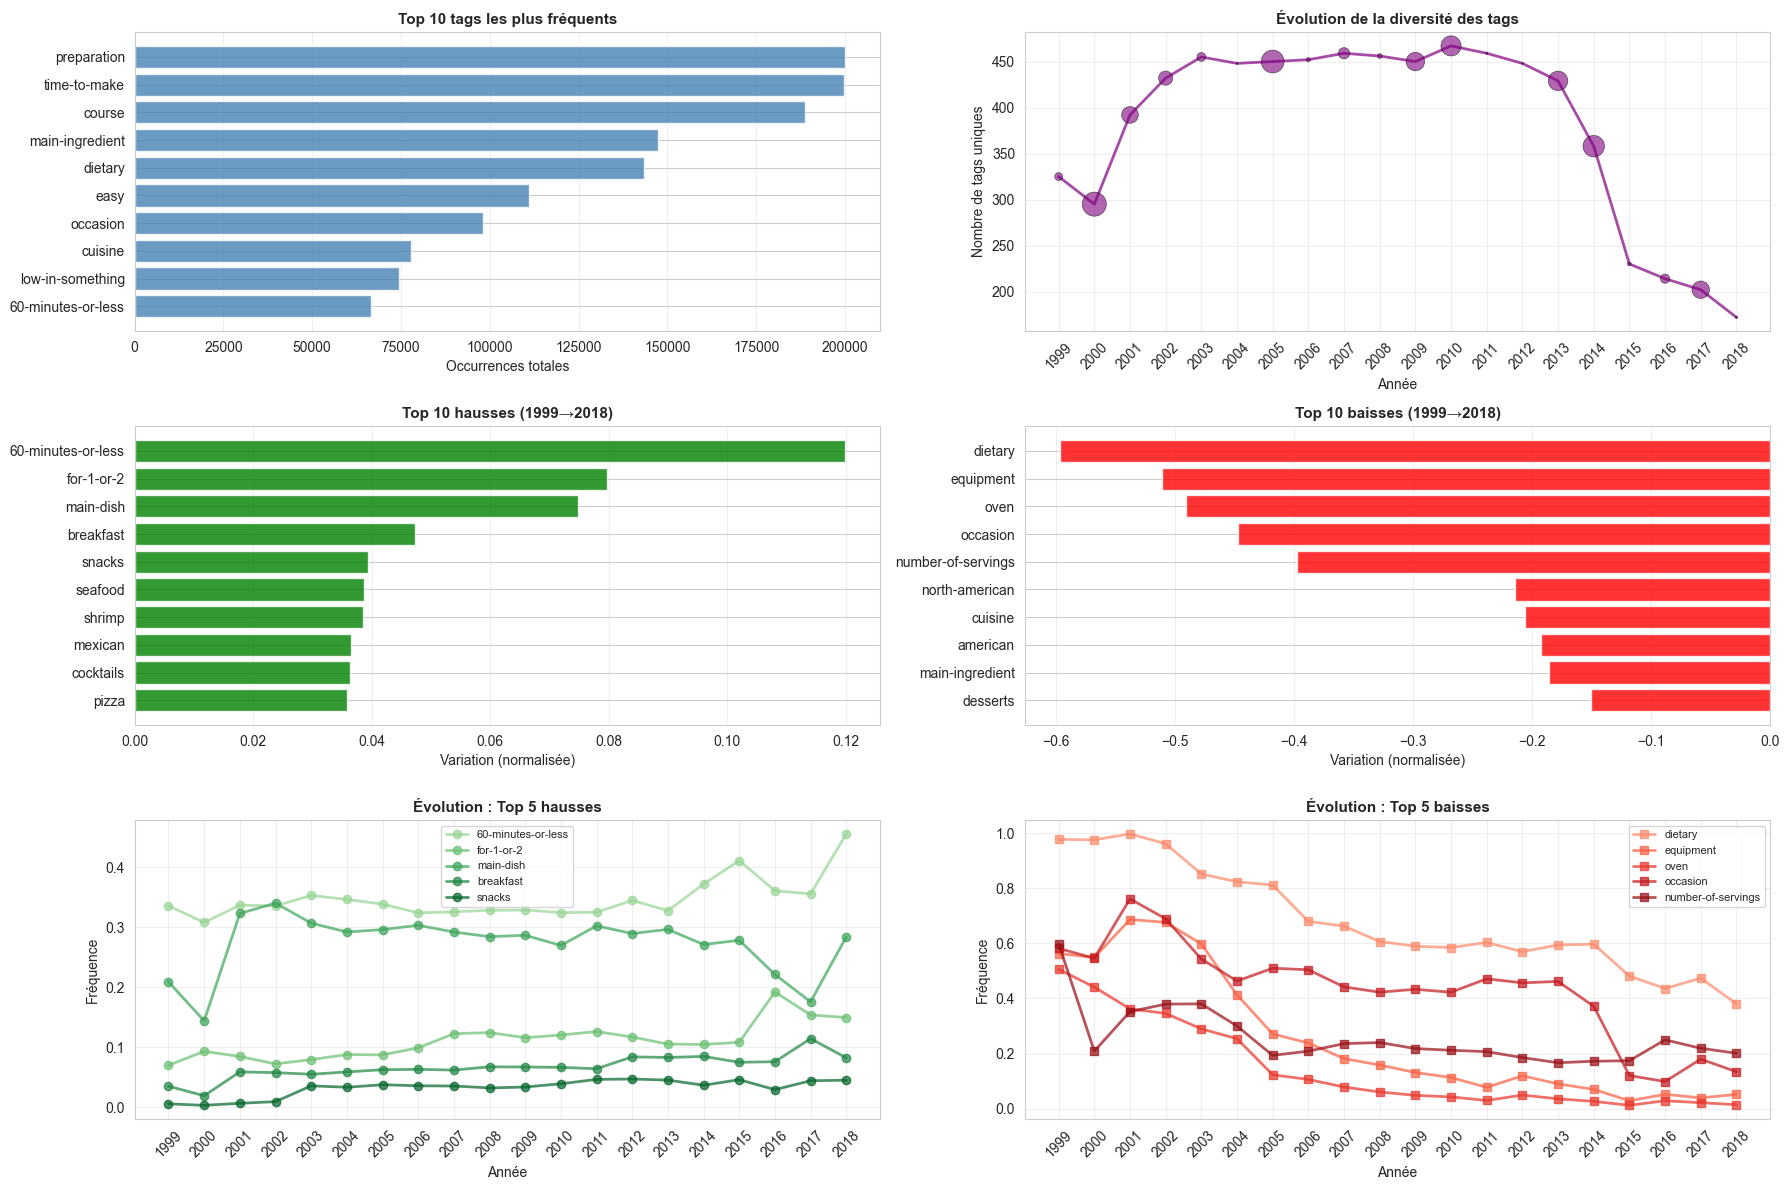


✅ Visualisation terminée !
   • 429 tags analysés (≥ 50 occurrences)
   • Diversité : 325 (1999) → 172 (2018)


In [14]:
# 📊 ANALYSE DES TAGS PAR ANNÉE

# --- PARAMÈTRES ---
NORMALIZE = True  # Normaliser par le nb de recettes de l'année
MIN_TOTAL_OCC = 50  # Seuil min d'occurrences globales
TOP_N = 10  # Top hausses/baisses à afficher
N_VARIATIONS = 5  # Nombre de tags à tracer

# --- 0. PRÉPARATION : NORMALISATION DES TAGS ---
print("🔄 Normalisation des tags en cours...")

# Exploser la liste de tags et normaliser (lowercase + strip)
df_tags = (
    df.select(['id', 'year', 'tags'])
    .explode('tags')
    .with_columns([
        pl.col('tags').str.to_lowercase().str.strip_chars().alias('tag_norm')
    ])
)

print(f"✅ {df_tags.shape[0]:,} tags individuels extraits")

# --- 1. FRÉQUENCE GLOBALE DES TAGS ---
freq_global_tags = (
    df_tags
    .group_by('tag_norm')
    .agg(pl.count('id').alias('total_count'))
    .filter(pl.col('total_count') >= MIN_TOTAL_OCC)
    .sort('total_count', descending=True)
    .to_pandas()
)

top_global_tags = freq_global_tags.head(TOP_N)

# --- 2. FRÉQUENCE PAR ANNÉE ---
freq_year_tag = (
    df_tags
    .group_by(['year', 'tag_norm'])
    .agg(pl.count('tag_norm').alias('count'))
    .to_pandas()
)

# Nombre de recettes par année
year_totals_tags = df.group_by('year').agg(pl.count('id').alias('n_recipes')).to_pandas()

# Joindre et normaliser
freq_year_tag = freq_year_tag.merge(year_totals_tags, on='year', how='left')
if NORMALIZE:
    freq_year_tag['freq'] = freq_year_tag['count'] / freq_year_tag['n_recipes']
else:
    freq_year_tag['freq'] = freq_year_tag['count']

# --- 3. CALCUL DES VARIATIONS ---
min_year_tags = int(df['year'].min())
max_year_tags = int(df['year'].max())

first_year_vals_tags = freq_year_tag[freq_year_tag['year'] == min_year_tags][['tag_norm', 'freq']].rename(columns={'freq': 'first'})
last_year_vals_tags = freq_year_tag[freq_year_tag['year'] == max_year_tags][['tag_norm', 'freq']].rename(columns={'freq': 'last'})

variation_tags = first_year_vals_tags.merge(last_year_vals_tags, on='tag_norm', how='outer').fillna(0)
variation_tags['delta'] = variation_tags['last'] - variation_tags['first']

# Filtrer pour avoir suffisamment d'occurrences
variation_tags = variation_tags.merge(freq_global_tags[['tag_norm', 'total_count']], on='tag_norm', how='left')
variation_tags = variation_tags[variation_tags['total_count'] >= MIN_TOTAL_OCC]

biggest_increase_tags = variation_tags.nlargest(TOP_N, 'delta')
biggest_decrease_tags = variation_tags.nsmallest(TOP_N, 'delta')

# --- 4. DIVERSITÉ (NOMBRE DE TAGS UNIQUES) ---
unique_per_year_tags = (
    df_tags
    .group_by('year')
    .agg(pl.n_unique('tag_norm').alias('n_unique'))
    .sort('year')
    .to_pandas()
)

# --- VISUALISATION ---
fig = plt.figure(figsize=(18, 12))

# (1) Top 10 tags (barres horizontales)
ax1 = plt.subplot(3, 2, 1)
ax1.barh(range(len(top_global_tags)), top_global_tags['total_count'], color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(top_global_tags)))
ax1.set_yticklabels(top_global_tags['tag_norm'])
ax1.invert_yaxis()
ax1.set_xlabel('Occurrences totales')
ax1.set_title(f'Top {TOP_N} tags les plus fréquents', fontweight='bold', fontsize=11)
ax1.grid(axis='x', alpha=0.3)

# (2) Évolution de la diversité
ax2 = plt.subplot(3, 2, 2)
w_div_tags = year_totals_tags['n_recipes'].values
sizes_div_tags = (w_div_tags / w_div_tags.max()) * 300
ax2.plot(unique_per_year_tags['year'], unique_per_year_tags['n_unique'], 
         color='purple', linewidth=2, alpha=0.7, label='Diversité observée', zorder=1)
ax2.scatter(unique_per_year_tags['year'], unique_per_year_tags['n_unique'],
            s=sizes_div_tags, color='purple', alpha=0.6, 
            edgecolors='black', linewidths=0.5, zorder=3)
ax2.set_xlabel('Année')
ax2.set_ylabel('Nombre de tags uniques')
ax2.set_title('Évolution de la diversité des tags', fontweight='bold', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(unique_per_year_tags['year'])
ax2.set_xticklabels([int(y) for y in unique_per_year_tags['year']], rotation=45)

# (3) Top hausses (barres horizontales)
ax3 = plt.subplot(3, 2, 3)
label_delta_tags = 'Variation (normalisée)' if NORMALIZE else 'Variation (occurrences)'
ax3.barh(range(len(biggest_increase_tags)), biggest_increase_tags['delta'], color='green', alpha=0.8)
ax3.set_yticks(range(len(biggest_increase_tags)))
ax3.set_yticklabels(biggest_increase_tags['tag_norm'])
ax3.invert_yaxis()
ax3.set_xlabel(label_delta_tags)
ax3.set_title(f'Top {TOP_N} hausses ({min_year_tags}→{max_year_tags})', fontweight='bold', fontsize=11)
ax3.grid(axis='x', alpha=0.3)

# (4) Top baisses (barres horizontales)
ax4 = plt.subplot(3, 2, 4)
ax4.barh(range(len(biggest_decrease_tags)), biggest_decrease_tags['delta'], color='red', alpha=0.8)
ax4.set_yticks(range(len(biggest_decrease_tags)))
ax4.set_yticklabels(biggest_decrease_tags['tag_norm'])
ax4.invert_yaxis()
ax4.set_xlabel(label_delta_tags)
ax4.set_title(f'Top {TOP_N} baisses ({min_year_tags}→{max_year_tags})', fontweight='bold', fontsize=11)
ax4.grid(axis='x', alpha=0.3)

# (5) Évolution de quelques tags en hausse
ax_inc = plt.subplot(3, 2, 5)
colors = plt.cm.Greens(np.linspace(0.4, 0.9, N_VARIATIONS))
for idx, (_, row) in enumerate(biggest_increase_tags.head(N_VARIATIONS).iterrows()):
    tag = row['tag_norm']
    data_tag = freq_year_tag[freq_year_tag['tag_norm'] == tag].sort_values('year')
    ax_inc.plot(data_tag['year'], data_tag['freq'], 
                marker='o', linewidth=2, alpha=0.7, color=colors[idx],
                label=tag)
ax_inc.set_xlabel('Année')
ax_inc.set_ylabel('Fréquence' if NORMALIZE else 'Occurrences')
ax_inc.set_title(f'Évolution : Top {N_VARIATIONS} hausses', fontweight='bold', fontsize=11)
ax_inc.legend(loc='best', fontsize=8)
ax_inc.grid(True, alpha=0.3)
ax_inc.set_xticks(unique_per_year_tags['year'])
ax_inc.set_xticklabels([int(y) for y in unique_per_year_tags['year']], rotation=45)

# (6) Évolution de quelques tags en baisse
ax_dec = plt.subplot(3, 2, 6)
colors = plt.cm.Reds(np.linspace(0.4, 0.9, N_VARIATIONS))
for idx, (_, row) in enumerate(biggest_decrease_tags.head(N_VARIATIONS).iterrows()):
    tag = row['tag_norm']
    data_tag = freq_year_tag[freq_year_tag['tag_norm'] == tag].sort_values('year')
    ax_dec.plot(data_tag['year'], data_tag['freq'], 
                marker='s', linewidth=2, alpha=0.7, color=colors[idx],
                label=tag)
ax_dec.set_xlabel('Année')
ax_dec.set_ylabel('Fréquence' if NORMALIZE else 'Occurrences')
ax_dec.set_title(f'Évolution : Top {N_VARIATIONS} baisses', fontweight='bold', fontsize=11)
ax_dec.legend(loc='best', fontsize=8)
ax_dec.grid(True, alpha=0.3)
ax_dec.set_xticks(unique_per_year_tags['year'])
ax_dec.set_xticklabels([int(y) for y in unique_per_year_tags['year']], rotation=45)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualisation terminée !")
print(f"   • {len(freq_global_tags):,} tags analysés (≥ {MIN_TOTAL_OCC} occurrences)")
print(f"   • Diversité : {unique_per_year_tags.iloc[0]['n_unique']:,} ({min_year_tags}) → {unique_per_year_tags.iloc[-1]['n_unique']:,} ({max_year_tags})")

#### Tests statistiques

In [15]:
# 📊 TESTS STATISTIQUES - ÉVOLUTION DES TAGS

print("="*80)
print("📊 STATISTIQUES - ÉVOLUTION DES TAGS")
print("="*80)

# --- 1. STATISTIQUES GLOBALES ---
print(f"\n1️⃣ STATISTIQUES GLOBALES")
print(f"   • Période            : {min_year_tags} → {max_year_tags}")
print(f"   • Total tags         : {len(freq_global_tags):,}")
print(f"   • Seuil occurrences  : ≥ {MIN_TOTAL_OCC}")

# --- 2. TOP 10 TAGS ---
print(f"\n2️⃣ TOP 10 TAGS (occurrences totales)")
print("-" * 80)
for idx, row in top_global_tags.head(10).iterrows():
    print(f"   {row['tag_norm']:30s} : {row['total_count']:>8,} occurrences")

# --- 3. PLUS FORTES HAUSSES ---
print(f"\n3️⃣ TOP 10 HAUSSES ({min_year_tags}→{max_year_tags})")
print("-" * 80)
for idx, row in biggest_increase_tags.head(10).iterrows():
    # Format adapté selon normalisation ou valeurs brutes
    delta_txt = f"{row['delta']:+.4f}" if NORMALIZE else f"{int(row['delta']):+,}"
    print(f"   {row['tag_norm']:30s} : {delta_txt:>12s}")

# --- 4. PLUS FORTES BAISSES ---
print(f"\n4️⃣ TOP 10 BAISSES ({min_year_tags}→{max_year_tags})")
print("-" * 80)
for idx, row in biggest_decrease_tags.head(10).iterrows():
    delta_txt = f"{row['delta']:+.4f}" if NORMALIZE else f"{int(row['delta']):+,}"
    print(f"   {row['tag_norm']:30s} : {delta_txt:>12s}")

# --- 5. DIVERSITÉ ---
print(f"\n5️⃣ ÉVOLUTION DE LA DIVERSITÉ")
print("-" * 80)
# Calcul des variations de diversité entre première et dernière année
first_unique_tags = unique_per_year_tags.iloc[0]['n_unique']
last_unique_tags = unique_per_year_tags.iloc[-1]['n_unique']
delta_unique_tags = last_unique_tags - first_unique_tags
pct_change_tags = (delta_unique_tags / first_unique_tags) * 100

print(f"   • {min_year_tags}          : {first_unique_tags:,} tags uniques")
print(f"   • {max_year_tags}          : {last_unique_tags:,} tags uniques")
print(f"   • Évolution           : {delta_unique_tags:+,} ({pct_change_tags:+.1f}%)")

# --- 6. RÉGRESSION LINÉAIRE SUR LA DIVERSITÉ ---
import statsmodels.api as sm
from scipy.stats import rankdata

def weighted_spearman(x, y, w):
    """Corrélation de Spearman pondérée par les poids w"""
    # Conversion en rangs
    rx = rankdata(x)
    ry = rankdata(y)
    # Moyennes pondérées des rangs
    mx = np.average(rx, weights=w)
    my = np.average(ry, weights=w)
    # Covariance et écarts-types pondérés
    cov_xy = np.average((rx - mx) * (ry - my), weights=w)
    sx = np.sqrt(np.average((rx - mx)**2, weights=w))
    sy = np.sqrt(np.average((ry - my)**2, weights=w))
    return cov_xy / (sx * sy)

# Variables pour la régression
X_div_tags = unique_per_year_tags['year'].values
y_div_tags = unique_per_year_tags['n_unique'].values
w_div_tags = year_totals_tags['n_recipes'].values

# Régression WLS (Weighted Least Squares)
X_const_div_tags = sm.add_constant(X_div_tags)
wls_div_tags = sm.WLS(y_div_tags, X_const_div_tags, weights=w_div_tags)
result_div_tags = wls_div_tags.fit()
y_pred_div_tags = result_div_tags.predict(X_const_div_tags)

# Calcul manuel du R² pondéré
r2_div_tags = 1 - np.average((y_div_tags - y_pred_div_tags)**2, weights=w_div_tags) / np.average((y_div_tags - np.average(y_div_tags, weights=w_div_tags))**2, weights=w_div_tags)

# Corrélation de Spearman pondérée
corr_sp_div_tags = weighted_spearman(X_div_tags, y_div_tags, w_div_tags)

print(f"\n6️⃣ RÉGRESSION WLS (diversité ~ année)")
print("-" * 80)
print(f"   • Corrélation Spearman : {corr_sp_div_tags:+.4f}")
print(f"   • Pente (β₁)           : {result_div_tags.params[1]:+.4f} tags/an")
print(f"   • R² pondéré           : {r2_div_tags:.4f} ({r2_div_tags*100:.1f}%)")
print(f"   • p-value              : {result_div_tags.pvalues[1]:.6e}")
print(f"   • Significativité      : {'✅ OUI' if result_div_tags.pvalues[1] < 0.10 else '❌ NON'} (α=0.10)")

print("\n" + "="*80)

📊 STATISTIQUES - ÉVOLUTION DES TAGS

1️⃣ STATISTIQUES GLOBALES
   • Période            : 1999 → 2018
   • Total tags         : 429
   • Seuil occurrences  : ≥ 50

2️⃣ TOP 10 TAGS (occurrences totales)
--------------------------------------------------------------------------------
   preparation                    :  199,873 occurrences
   time-to-make                   :  199,728 occurrences
   course                         :  188,810 occurrences
   main-ingredient                :  147,262 occurrences
   dietary                        :  143,476 occurrences
   easy                           :  111,063 occurrences
   occasion                       :   98,148 occurrences
   cuisine                        :   77,688 occurrences
   low-in-something               :   74,287 occurrences
   60-minutes-or-less             :   66,553 occurrences

3️⃣ TOP 10 HAUSSES (1999→2018)
--------------------------------------------------------------------------------
   60-minutes-or-less             :

#### Interprétation

> **💡 Interprétation :**
>
> L'analyse des tags révèle une **évolution des pratiques de catégorisation** des recettes au fil du temps.
>
> **📈 Tendances montantes** : Les tags liés aux **régimes alimentaires modernes** (ex: *gluten-free*, *low-carb*, *vegan*) et aux **occasions spécifiques** (ex: *weeknight*, *quick*, *easy*) connaissent une **forte progression**, reflétant une **adaptation aux préoccupations santé contemporaines** et à la recherche de **praticité**.
>
> **📉 Tendances descendantes** : Les tags traditionnels ou génériques (ex: *main-dish*, *desserts*, *american*) sont en **recul relatif**, suggérant une **spécialisation accrue** des catégories et une **recherche de précision** dans la classification des recettes.
>
> **🔻 Évolution de la diversité** : Le nombre de tags uniques suit une trajectoire similaire à celle des ingrédients, avec une **diminution significative** après 2007. Cette **standardisation progressive** traduit à la fois la **baisse du volume de recettes** et une **convergence vers un vocabulaire de catégorisation plus homogène**, probablement influencée par les usages communautaires dominants.